# Azure Interpretability

## Problem statements
This is an Oil and Gas use-case using data from Volve dataset, owned by  [Equinor](https://www.equinor.com/en/how-and-why/digitalisation-in-our-dna/volve-field-data-village-download.html) and made publicly available in 2018 to support innovations in the industry. A subset of the data was prepared by [SPWLA PDDA](https://github.com/pddasig/Machine-Learning-Competition-2020) for a data science competition. For this demo, we use a subsample extract of this data.

## Well Logs
Well logs are collected during well drilling. The logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which are essential for characterizing the subsurface for explorations. 

![Example of Well Log](image/WL.png)

Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. 

Other logs, such as Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field, due to financial or operational constraints.
Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.

Here we have a pretrained ML model to predict DTC log to improve subsurface characterization. 

The model is developed from  a set of “easy-to-acquire” conventional logs:
- Gamma Ray (Gamma_Ray in API) : lithology indicator,
- Resistetivy (Deep_Resistivity & Medium_Resistivity in Ohm/meter): fromation fluid indicators, 
- Density (Density in gr/m^3): hycrocarbon density undicator,
- Neutron (Neutron_Porosity in dec): porosity indicator.

and the target is
- Compressional Travel-time (DTC in nanosecond/ft).

# ML interpretability

We set up this on **Azure Machine Learning Compute Instance**, you can also clone the repo on your local machine.

Here in this tutorial, we want to understand how this model makes the predictions, 
- For any single prediction from a model, the impact of each feature in the data on that particular prediction?
- Which features have the highest impact on the model?
- How features interact with each other?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
import pickle
from azureml.core import Experiment
from azureml.core import Workspace, Datastore, Dataset
from interpret.ext.blackbox import TabularExplainer
from azureml.contrib.interpret.explanation.explanation_client import ExplanationClient
from azureml.contrib.interpret.visualize import ExplanationDashboard
import shap
# Check core SDK version number
import azureml.core

datafile = 'train_clean.csv'
modelfile = 'DTC.pkl'
target = 'DTC'
experiment_name = 'demo'

https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-register-datasets#on-the-web



In [3]:
ws = Workspace.from_config()

print('SDK version:', azureml.core.VERSION)
print(ws.name, ws.resource_group, ws.location, sep='\n')

SDK version: 1.5.0
Monarch-alice
Monarch-Alice-rg
eastus2


In [4]:

# print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep="\n")
experiment = Experiment(ws, experiment_name)
run = experiment.start_logging()

In [5]:
# List all datastores registered in the current workspace
datastores = ws.datastores
for name, datastore in datastores.items():
    print(name, datastore.datastore_type)

mladsdata AzureBlob
mlads AzureBlob
mlads_table AzureBlob
workspacefilestore AzureFile
workspaceblobstore AzureBlob


In [6]:
# create and register a Datastore to be able to connect to your Azure Storage account

blob_datastore_name = 'mladsdata' # Name of the datastore to workspace [this can be customized]
account_name = os.getenv("BLOB_ACCOUNTNAME", "<STORAGE-ACCOUNT-NAME>") # Storage account name
account_key = os.getenv("BLOB_ACCOUNT_KEY", \
                        "<ACCOUNT-KEY>") \
                        # Storage account key - you can find this under "Access keys" --> key1 --> Key in Azure
# container_name = os.getenv("BLOB_CONTAINER", "gridding-outputs") # Name of Azure blob container

container_name = os.getenv("BLOB_CONTAINER", "mladstable") # Name of Azure blob container


blob_datastore = Datastore.register_azure_blob_container(workspace = ws, 
                                                         datastore_name = blob_datastore_name, 
                                                         container_name = container_name, 
                                                         account_name = account_name,
                                                         account_key = account_key)

In [7]:
# display all of the files we uploaded into the blob storage
for blob in blob_datastore.blob_service.list_blobs('mladstable'):
    print(blob.name)

DTC.pkl
train_clean.csv


In [8]:
data = Dataset.Tabular.from_delimited_files(path = [(blob_datastore, datafile)]).to_pandas_dataframe()
# preview the first 3 rows of the dataset
data

Neutron_Porosity  Deep_Resistivity  Medium_Resistivity  Gamma_Ray  \
0               0.1530            2.6388              2.6855    14.0231   
1               0.1551            2.6594              2.6945    14.6457   
2               0.1469            2.6425              2.6482    14.8459   
3               0.1442            2.6215              2.6004    13.2664   
4               0.1425            2.6234              2.5870    12.5315   
5               0.1392            2.6579              2.6228    13.3883   
6               0.1408            2.7168              2.6974    14.5353   
7               0.1383            2.7831              2.7800    16.7107   
8               0.1392            2.8440              2.8452    18.7890   
9               0.1485            2.8956              2.8897    20.5274   
10              0.1550            2.9395              2.9142    22.7808   
11              0.1550            2.9748              2.9097    23.2247   
12              0.1561            3.0004              2.8877    20.2112   
13              0.1546            3.0172              2.8773    17.1506   
14              0.1510            3.0243              2.8879    17.2120   
15              0.1522            3.0199              2.9003    17.5431   
16              0.1498            3.0085              2.9004    17.8674   
17              0.1438            3.0081              2.9102    17.2963   
18              0.1391            3.0350              2.9547    17.6269   
19              0.1381            3.0929              3.0309    18.3378   
20              0.1384            3.1676              3.1100    18.4168   
21              0.1370            3.2352              3.1558    17.9477   
22              0.1351            3.2834              3.1610    17.4491   
23              0.1285            3.3306              3.1873    15.9224   
24              0.1159            3.4198              3.3427    16.5749   
25              0.1059            3.5618              3.6488    20.3258   
26              0.0988            3.7194              4.0051    21.9512   
27              0.0912            3.8279              4.2287    23.0045   
28              0.0864            3.8629              4.2615    22.9396   
29              0.0843            3.8704              4.2473    20.3003   
...                ...               ...                 ...        ...   
7993            0.0973            3.1388              3.1680    70.5728   
7994            0.0846            3.2128              3.2815    59.8639   
7995            0.0769            3.2765              3.4238    53.1951   
7996            0.0726            3.3517              3.5870    49.8536   
7997            0.0699            3.4371              3.7511    48.6662   
7998            0.0682            3.5184              3.9433    45.9647   
7999            0.0673            3.5815              4.1196    44.3836   
8000            0.0675            3.6299              4.2359    43.3453   
8001            0.0708            3.6683              4.3142    43.0158   
8002            0.0734            3.7022              4.3993    43.0748   
8003            0.0778            3.7153              4.4693    43.3170   
8004            0.0825            3.7240              4.5307    44.1495   
8005            0.0916            3.7041              4.5333    44.5849   
8006            0.1025            3.6672              4.4952    45.2305   
8007            0.1156            3.6208              4.4229    45.5117   
8008            0.1238            3.5597              4.3821    45.6308   
8009            0.1330            3.5089              4.3356    47.7546   
8010            0.1413            3.4301              4.2012    51.2103   
8011            0.1475            3.3494              4.1043    55.0319   
8012            0.1495            3.2412              3.9654    59.8668   
8013            0.1481            3.0801              3.6521    64.8170   
8014            0.1410         

In [9]:
features = list(data.columns)
features.remove(target)
print(features)

['Neutron_Porosity', 'Deep_Resistivity', 'Medium_Resistivity', 'Gamma_Ray', 'Density']


# Model
Here is a pre-trained model, we trained this model using azureml automl library, the model is a LightGBM with the following parameters:

In [10]:
# Download the blob to a local file
# Add 'DOWNLOAD' before the .txt extension so you can see both files in the data directory
download_file_path = os.path.join(os.getcwd(), modelfile)
print("\nDownloading blob to \n\t" + download_file_path)

blob_datastore.download(os.getcwd(), prefix=None, overwrite=True, show_progress=True)
    
fitted_model = pickle.load(open(download_file_path, "rb"))
fitted_model.named_steps


	/mnt/batch/tasks/shared/LS_root/mounts/clusters/mlads-demo/code/MLADS/DTC.pkl
Downloaded DTC.pkl, 1 files out of an estimated total of 2
Downloaded train_clean.csv, 2 files out of an estimated total of 2


{'datatransformer': DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
         feature_sweeping_config=None, feature_sweeping_timeout=None,
         featurization_config=None, force_text_dnn=None,
         is_cross_validation=None, is_onnx_compatible=None, logger=None,
         observer=None, task=None, working_dir=None),
 'MaxAbsScaler': MaxAbsScaler(copy=True),
 'LightGBMRegressor': LightGBMRegressor(boosting_type='gbdt', class_weight=None,
          colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
          max_depth=-1, min_child_samples=20, min_child_weight=0.001,
          min_split_gain=0.0, n_estimators=100, n_jobs=1, num_leaves=31,
          objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
          silent=True, subsample=1.0, subsample_for_bin=200000,
          subsample_freq=0, verbose=-1)}

In [11]:
X_train, y_train = data[features], data[target]

y_train_pred = fitted_model.predict(X_train)

This is a couple of plots for model performance:

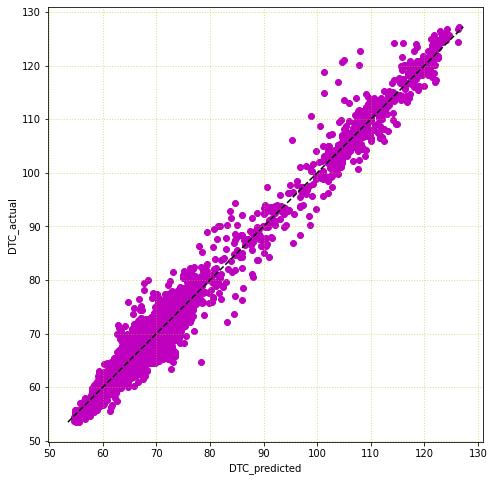

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(y_train_pred, y_train.values, marker="o", color='m')

_id = np.linspace(np.min((y_train_pred.min(), y_train.min())), np.max((y_train_pred.max(), y_train.max())))
plt.plot(_id, _id, color="k", ls="--")
plt.grid(color="y", linestyle=":", linewidth=1, alpha=0.5)
plt.xlabel(target+"_predicted")
plt.ylabel(target+"_actual")

ax.set_aspect("equal")

[]

<Figure size 432x288 with 0 Axes>

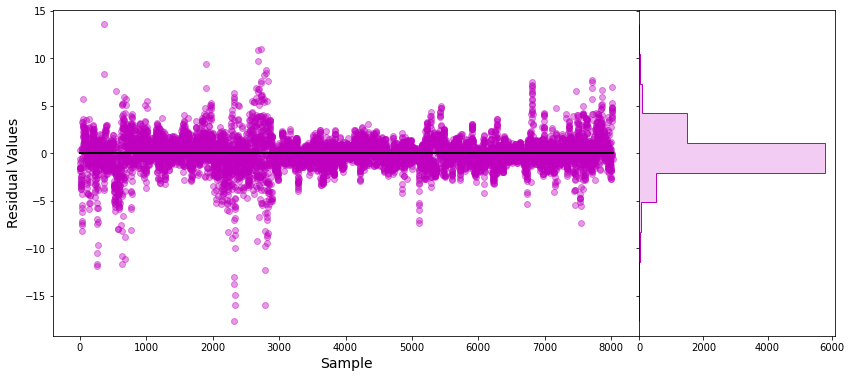

In [13]:
plt.figure()
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={"width_ratios": [3, 1], "wspace": 0, "hspace": 0})

f.set_figheight(6)
f.set_figwidth(14)

a0.plot(y_train_pred-y_train.values, "o", color='m', alpha=0.4)
a0.plot([0, len(y_train_pred-y_train.values)], [0, 0], "k", lw=2)
a0.set_ylabel("Residual Values", fontsize=14)
a0.set_xlabel('Sample', fontsize=14)

a1.hist(y_train_pred-y_train.values, orientation="horizontal", color='m', bins=10, histtype="step")
a1.hist(y_train_pred-y_train.values, orientation="horizontal", color='m', alpha=0.2, bins=10)
a1.set_yticklabels([])

# Model Interpretability

In [14]:
tabular_explainer = TabularExplainer(fitted_model, X_train, features=features)
global_explanation = tabular_explainer.explain_global(X_train)

In [15]:
print(y_train_pred.mean())

71.70635076762089


In [16]:
ExplanationDashboard(global_explanation, fitted_model, X_train)

# Upload via ExplanationClient 

In [17]:
client = ExplanationClient.from_run(run)
comment = 'Explanation Dashboard for DTC'
client.upload_model_explanation(global_explanation, comment=comment)

# Limitations to AML Interpret
We can extract the SHAP values array from global_explanation, and do furthur analysis on top of what is available from interpter module:

In [18]:
shap_values = pd.DataFrame(np.array(global_explanation.local_importance_values), columns=features)
shap_values.head()

Neutron_Porosity  Deep_Resistivity  Medium_Resistivity  Gamma_Ray  Density
0              2.13              3.34               -0.81      -1.15    -1.15
1              2.55              3.29               -0.94      -0.58    -1.14
2              2.18              3.52               -0.57      -0.56    -0.91
3              1.18              3.12               -0.06      -1.08    -0.81
4              1.14              2.93               -0.02      -1.14    -0.74

In [19]:
Xt = pd.DataFrame(X_train, columns=features)
Xt.head()

Neutron_Porosity  Deep_Resistivity  Medium_Resistivity  Gamma_Ray  Density
0              0.15              2.64                2.69      14.02     2.51
1              0.16              2.66                2.69      14.65     2.51
2              0.15              2.64                2.65      14.85     2.50
3              0.14              2.62                2.60      13.27     2.51
4              0.14              2.62                2.59      12.53     2.50

# Feature interactions

How do the features interact with each other? For each feature -**fea**-, rank the interactions with other features from highest to lowest:

In [20]:
interaction_dict = {}
for fea in shap_values.columns:
    arr = list(shap.common.approximate_interactions(fea, shap_values.values, Xt[list(shap_values.columns)]))
    arr.remove(arr[-1])
    interaction_dict[fea] = [shap_values.columns[c] for c in arr]

pd.DataFrame.from_dict(interaction_dict)

Neutron_Porosity    Deep_Resistivity Medium_Resistivity  \
0    Deep_Resistivity           Gamma_Ray          Gamma_Ray   
1  Medium_Resistivity    Neutron_Porosity   Neutron_Porosity   
2             Density             Density            Density   
3           Gamma_Ray  Medium_Resistivity   Deep_Resistivity   

            Gamma_Ray             Density  
0    Deep_Resistivity           Gamma_Ray  
1  Medium_Resistivity    Neutron_Porosity  
2    Neutron_Porosity    Deep_Resistivity  
3             Density  Medium_Resistivity


Then, for each feature -**fea**- :
- What is the marginal contribution of **fea**  to the target (**DTC**), for each observation?
- and what is the feature that has highest interaction with **fea**?

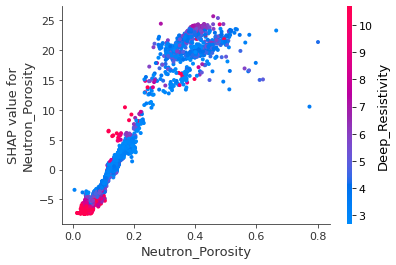

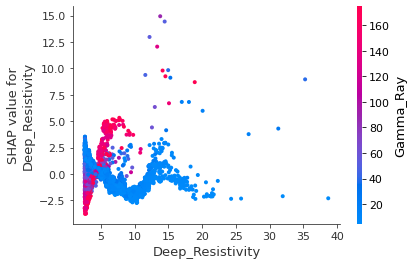

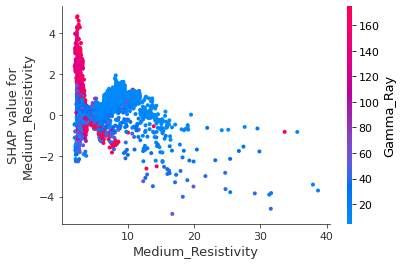

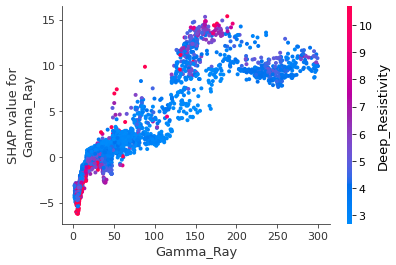

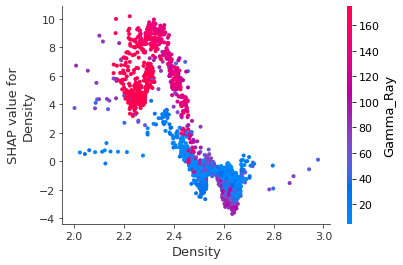

In [21]:
axes = []
for fea in features:
    fig, ax = plt.subplots()
    shap.dependence_plot(fea, shap_values.values, Xt, ax=ax, show=False)
    axes.append((fig,ax))

In [22]:
for item in axes:
    fig = item[0]
    ax = item[1]
    run.log_image(ax.get_xlabel(), plot=fig)

# Complete the AML run

In [23]:
run.tag('TabularRegression')
run.complete()


In [24]:
run

Run(Experiment: demo,
Id: 72137501-83a9-4d89-a8da-16ad3c6c56ac,
Type: None,
Status: Running)